In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv('conversion_data.csv')
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [60]:
total_visitor_country = data[['country', 'converted']].groupby('country').count().reset_index()
total_visitor_country.columns = ['country', 'visitors']
total_conversion_country = data[['country', 'converted']].groupby('country').sum().reset_index()
total_country = pd.merge(total_visitor_country, total_conversion_country, on='country')
total_country['conversion_rate'] = total_country['converted'] / total_country['visitors']*100

In [64]:
data['converted'].value_counts()

0    306000
1     10200
Name: converted, dtype: int64

Text(0.5,0,'Country')

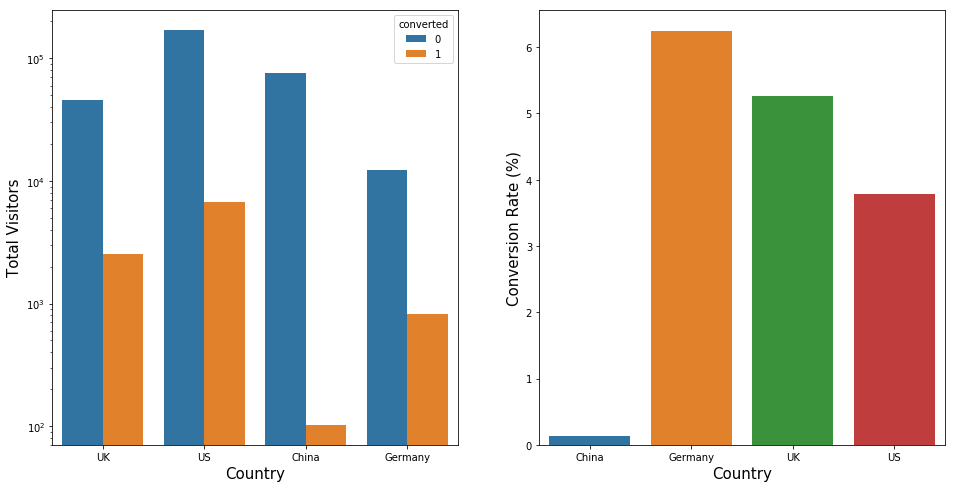

In [75]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(1,2,1)
sns.countplot(x='country', hue='converted', data=data, ax=ax1)
ax1.set_yscale('log')
ax1.set_ylabel('Total Visitors',  fontsize=15)
ax1.set_xlabel('Country', fontsize=15)
ax2 = fig.add_subplot(1,2,2)
sns.barplot(x='country', y='conversion_rate', data=total_country, ax=ax2)
ax2.set_ylabel('Conversion Rate (%)', fontsize=15)
ax2.set_xlabel('Country', fontsize=15)

### Observation: Low conversion rate for Chinese users

C:\Users\Mengfan\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Mengfan\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Age')

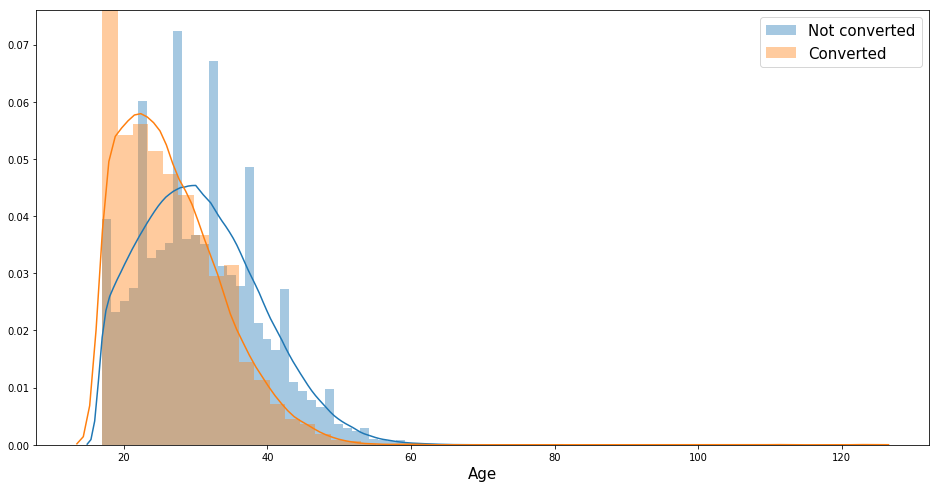

In [82]:
fig = plt.figure(figsize=(16,8))
sns.distplot(data.loc[data['converted']==0, 'age'], label='Not converted')
sns.distplot(data.loc[data['converted']==1, 'age'], label='Converted')
plt.legend(fontsize=15)
plt.xlabel('Age', fontsize=15)

### Observation: converted users have a younger distribution than non-converted users

In [83]:
data['source'].value_counts()

Seo       155040
Ads        88740
Direct     72420
Name: source, dtype: int64

Text(0.5,0,'Source')

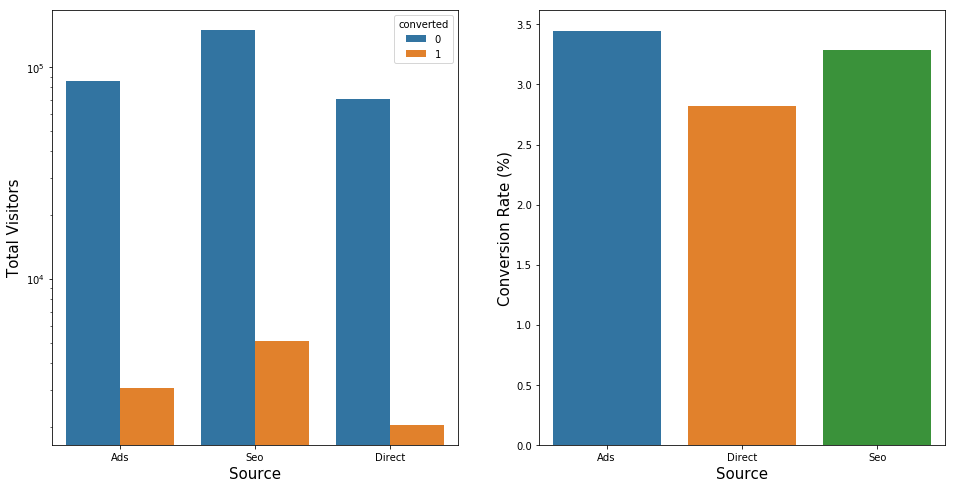

In [85]:
total_visitor_source = data[['source', 'converted']].groupby('source').count().reset_index()
total_visitor_source.columns = ['source', 'visitors']
total_conversion_source = data[['source', 'converted']].groupby('source').sum().reset_index()
total_source = pd.merge(total_visitor_source, total_conversion_source, on='source')
total_source['conversion_rate'] = total_source['converted'] / total_source['visitors']*100


fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(1,2,1)
sns.countplot(x='source', hue='converted', data=data, ax=ax1)
ax1.set_yscale('log')
ax1.set_ylabel('Total Visitors',  fontsize=15)
ax1.set_xlabel('Source', fontsize=15)
ax2 = fig.add_subplot(1,2,2)
sns.barplot(x='source', y='conversion_rate', data=total_source, ax=ax2)
ax2.set_ylabel('Conversion Rate (%)', fontsize=15)
ax2.set_xlabel('Source', fontsize=15)

### Comment: conversion rate is comparable with different sources

C:\Users\Mengfan\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Mengfan\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'total_pages_visited')

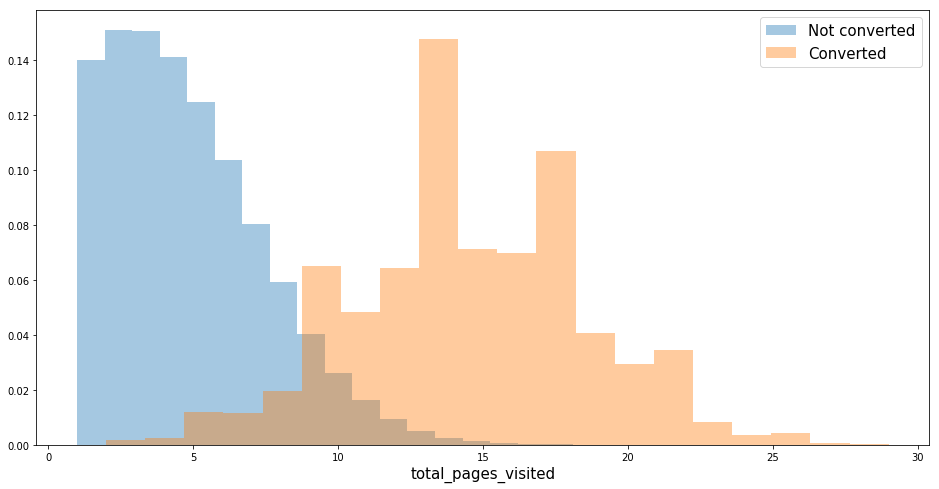

In [92]:
fig = plt.figure(figsize=(16,8))
sns.distplot(data.loc[data['converted']==0, 'total_pages_visited'], bins=20, kde=False, norm_hist=True, label='Not converted')
sns.distplot(data.loc[data['converted']==1, 'total_pages_visited'], bins=20, kde=False, norm_hist=True, label='Converted')
plt.legend(fontsize=15)
plt.xlabel('total_pages_visited', fontsize=15)

### Observation: converted users have a significantly larger number of page views than non-converted

## Part 2. predictive modeling

In [128]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
le = LabelEncoder()
le.fit(data['country'])
X['country_code'] = le.transform(X['country'])
le.fit(data['source'])
X['source_code'] = le.transform(X['source'])
X = X[['new_user', 'total_pages_visited', 'country_code', 'source_code']]
X.head()

,new_user,total_pages_visited,country_code,source_code
0,1,1,2,0
1,1,5,3,2
2,1,4,3,2
3,1,5,0,2
4,1,6,3,2


In [156]:
from sklearn.model_selection import train_test_split
X_train, X_holdout, y_train, y_holdout = train_test_split(X,y, test_size=0.5, random_state=0, shuffle=True, stratify=y )
print(len(y_train), len(y_holdout))
print(y_holdout.value_counts(normalize=True))
print(y_train.value_counts(normalize=True))

158100 158100
0    0.967742
1    0.032258
Name: converted, dtype: float64
0    0.967742
1    0.032258
Name: converted, dtype: float64


In [157]:
# Test using a simple decision tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
dtree=DecisionTreeClassifier(random_state=1, max_depth=2, min_samples_leaf=10, max_leaf_nodes=20, min_samples_split=10)
dtree.fit(X_train,y_train)
pred_prob_train = dtree.predict_proba(X_train)
roc_auc_train = roc_auc_score(y_train, pd.DataFrame(pred_prob_train)[1])
print('ROC_AUC for train set is {}'.format(roc_auc_train))

pred_prob_holdout = dtree.predict_proba(X_holdout)
roc_auc_holdout = roc_auc_score(y_holdout, pd.DataFrame(pred_prob_holdout)[1])
print('ROC_AUC for test set is {}'.format(roc_auc_holdout))

ROC_AUC for train set is 0.9582386928104575
ROC_AUC for test set is 0.9546796949891069


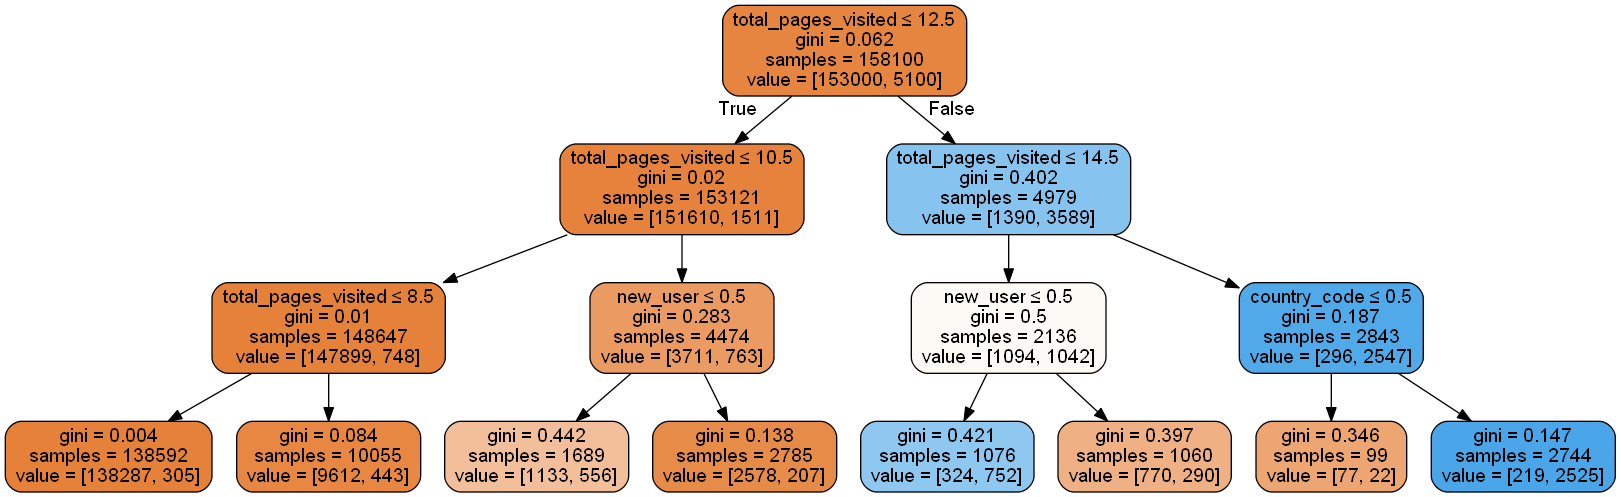

In [150]:

# Plot the tree structure
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
               feature_names=X.columns)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())



In [151]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train,y_train)

pred_prob_train = rf.predict_proba(X_train)
roc_auc_train = roc_auc_score(y_train, pd.DataFrame(pred_prob_train)[1])
print('ROC_AUC for train set is {}'.format(roc_auc_train))

pred_prob_holdout = rf.predict_proba(X_holdout)
roc_auc_holdout = roc_auc_score(y_holdout, pd.DataFrame(pred_prob_holdout)[1])
print('ROC_AUC for test set is {}'.format(roc_auc_holdout))

ROC_AUC for train set is 0.9868215699090094
ROC_AUC for test set is 0.9806165545303087


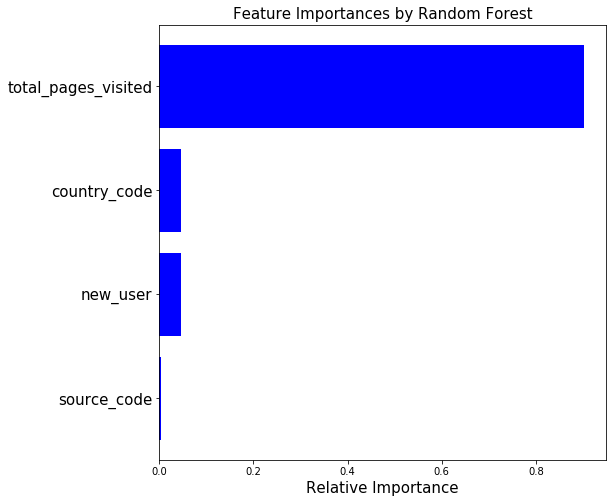

In [152]:
# Plot feature importance indicated by the Random Forest model

features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

fig = plt.figure(figsize=(8, 8))
plt.title('Feature Importances by Random Forest', fontsize=15)
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices], fontsize=15)
plt.xlabel('Relative Importance', fontsize=15)
plt.show()

In [153]:
# XGBoost

from xgboost import XGBClassifier
from xgboost import plot_importance

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

pred_prob_train = xgb.predict_proba(X_train)
roc_auc_train = roc_auc_score(y_train, pd.DataFrame(pred_prob_train)[1])
print('ROC_AUC for train set is {}'.format(roc_auc_train))

pred_prob_holdout = xgb.predict_proba(X_holdout)
roc_auc_holdout = roc_auc_score(y_holdout, pd.DataFrame(pred_prob_holdout)[1])
print('ROC_AUC for test set is {}'.format(roc_auc_holdout))

ROC_AUC for train set is 0.9854538254517494
ROC_AUC for test set is 0.9836495444059977


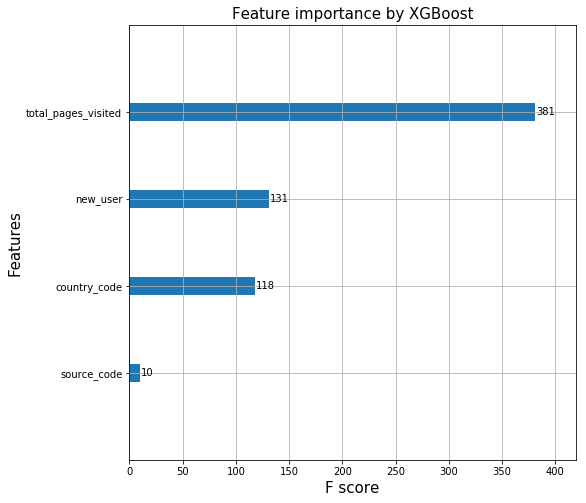

In [154]:
# Plot feature importance indicated by the XGBoost model

fig, ax = plt.subplots(figsize=(8, 8))
plot_importance(xgb, ax=ax)
ax.set_xlabel('F score', fontsize=15)
ax.set_ylabel('Features', fontsize=15)
ax.set_title('Feature importance by XGBoost', fontsize=15)
plt.show()

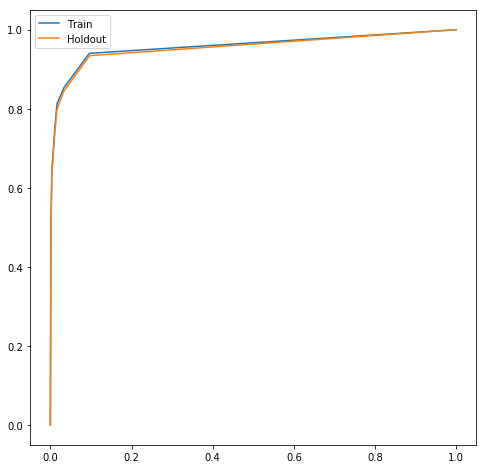

In [159]:
fpr1,tpr1,thresholds1 = roc_curve(y_train, pd.DataFrame(pred_prob_train)[1])
#roc_auc = auc(fpr, tpr)

fpr2,tpr2,thresholds2 = roc_curve(y_holdout, pd.DataFrame(pred_prob_holdout)[1])
#roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(8,8))
plt.plot(fpr1,tpr1,label='Train')
plt.plot(fpr2,tpr2,label='Holdout')
plt.legend()
plt.show()

### Comment: total page viewed has the strongest effect on conversion